In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


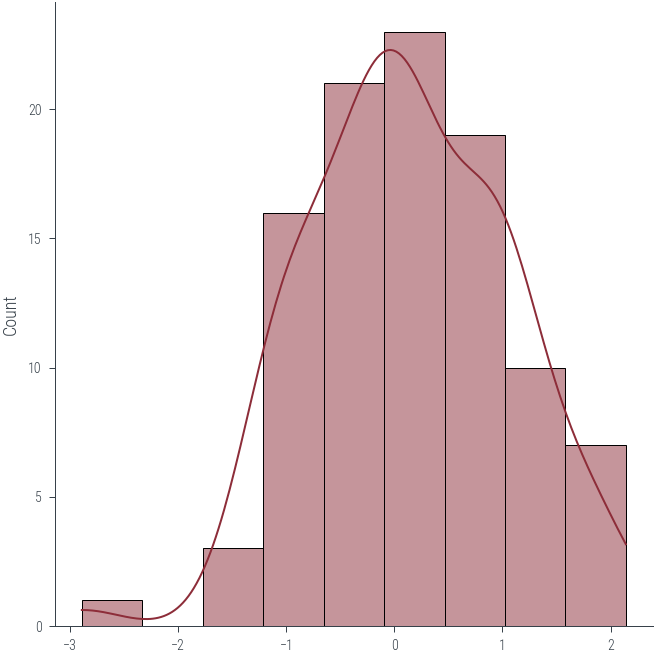

In [4]:
dist = torch.distributions.Normal(0, 1)

# Generate data
data = dist.sample((100,))

# Plot data
_ = sns.displot(data, kde=True)

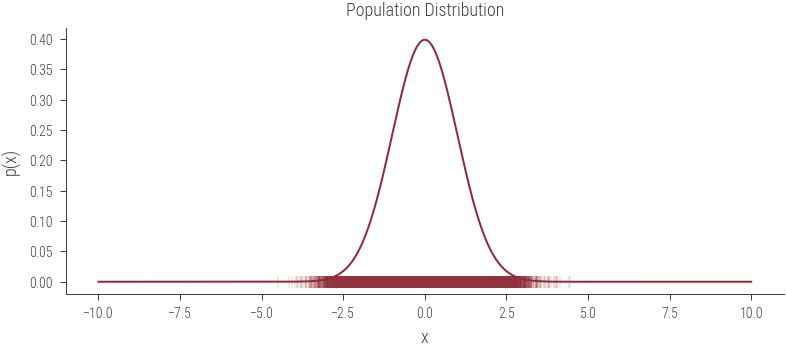

In [17]:
# Population
norm = torch.distributions.Normal(0, 1)
xs = torch.linspace(-10, 10, 1000)
ys = torch.exp(norm.log_prob(xs))
plt.plot(xs, ys)
plt.title('Population Distribution')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.savefig('../figures/mle/population-dist.pdf')

population = norm.sample((100000,))
plt.scatter(population, torch.zeros_like(population),  marker='|', alpha=0.1)
plt.savefig('../figures/mle/population.pdf')


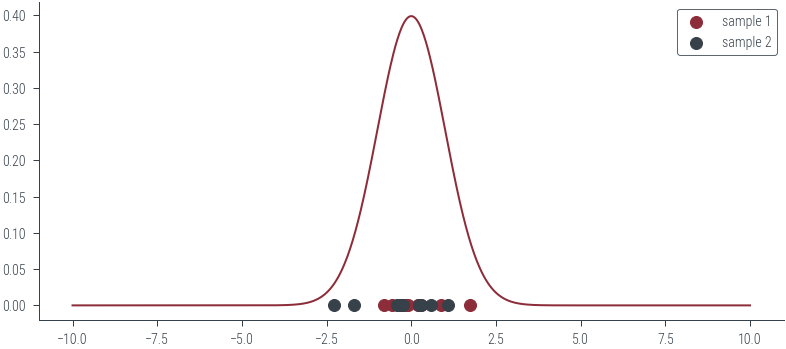

In [24]:
plt.plot(xs, ys)
sample_1 = population[torch.randperm(population.size(0))[:10]]
sample_2 = population[torch.randperm(population.size(0))[:10]]
plt.scatter(sample_1, torch.zeros_like(sample_1),label='sample 1')
plt.scatter(sample_2, torch.zeros_like(sample_2),  label='sample 2')
plt.legend()
plt.savefig('../figures/mle/sample.pdf')


In [5]:
norm = torch.distributions.Normal(0, 1)
population = norm.sample((100000,))

def plot_fit(seed, num_samples):
    torch.manual_seed(seed)
    # Select a random sample of size num_samples from the population
    data = population[torch.randperm(population.shape[0])[:num_samples]]
    mu = data.mean()
    sigma_2 = data.var(correction=0)

    # Plot data scatter
    plt.scatter(data, torch.zeros_like(data), color='black', marker='x', zorder=10, label='samples')
    # Plot true distribution
    x = torch.linspace(-3, 3, 100)
    plt.plot(x, norm.log_prob(x).exp(), color='black', label='true distribution')
    # Plot estimated distribution
    est = torch.distributions.Normal(mu, sigma_2.sqrt())
    plt.plot(x, est.log_prob(x).exp(), color='red', label='estimated distribution')
    plt.legend()
    plt.title(f"Sample size: {num_samples}\n" +fr"Sample parameters: $\hat{{\mu}}={mu:0.02f}$, $\hat{{\sigma^2}}={sigma_2:0.02f}$")
    plt.ylim(-0.1, 1.2)
    plt.xlabel("$x$")
    plt.ylabel("$p(x)$")
    plt.savefig(f"../figures/mle/biased-mle-normal-{num_samples}-{seed}.pdf", bbox_inches='tight')
    return mu, sigma_2

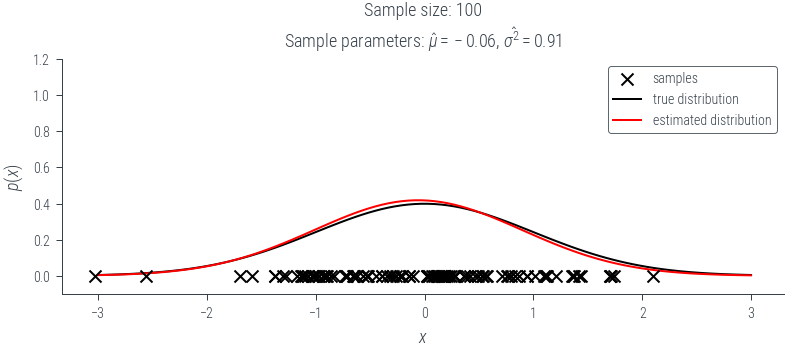

In [38]:
N_samples = 100
mus = {}
sigmas = {}
for draw in [3, 4, 5, 10, 100]:
    mus[draw] = torch.zeros(N_samples)
    sigmas[draw] = torch.zeros(N_samples)
    for i in range(N_samples):
        plt.clf()
        mus[draw][i], sigmas[draw][i] = plot_fit(i, draw)


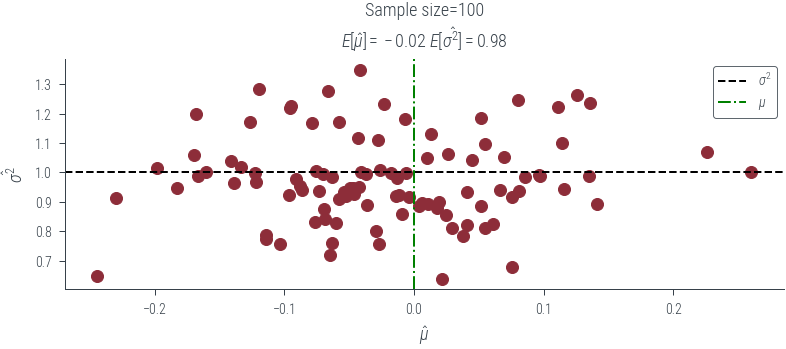

In [39]:
for draw in [3, 4, 5, 10, 100]:
    plt.clf()
    plt.scatter(mus[draw], sigmas[draw])
    plt.axhline(y=1, color='k', linestyle='--', label=r'$\sigma^2$')
    plt.axvline(x=0, color='g', linestyle='-.', label=r'$\mu$')
    plt.xlabel(r'$\hat{\mu}$')
    plt.ylabel(r'$\hat{\sigma^2}$')
    plt.legend()
    plt.title(f'Sample size={draw}\n'+ fr'$E[\hat{{\mu}}] = {mus[draw].mean():0.2f}$ $E[\hat{{\sigma^2}}] = {sigmas[draw].mean():0.2f}$ ')
    plt.savefig(f"../figures/mle/biased-mle-normal-scatter-{draw}.pdf", bbox_inches='tight')
    #plt.clf()

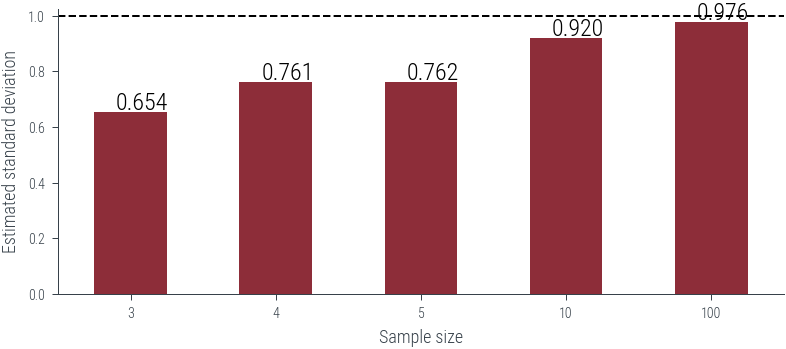

In [53]:
df = pd.DataFrame({draw: 
              sigmas[draw].numpy() 
              for draw in [3, 4, 5, 10, 100]}).mean()
df.plot(kind='bar', rot=0)
plt.axhline(1, color='k', linestyle='--')
# Put numbers on top of bars
for i, v in enumerate(df):
    plt.text(i - .1, v + .01, f'{v:.3f}', color='k', fontsize=12)

plt.xlabel("Sample size (N)")
plt.ylabel("Estimated standard deviation")
plt.savefig('../figures/biased-mle-variance-quality.pdf', bbox_inches='tight')

3      0.981293
4      1.014205
5      0.952345
10     1.022295
100    0.985779
dtype: float64

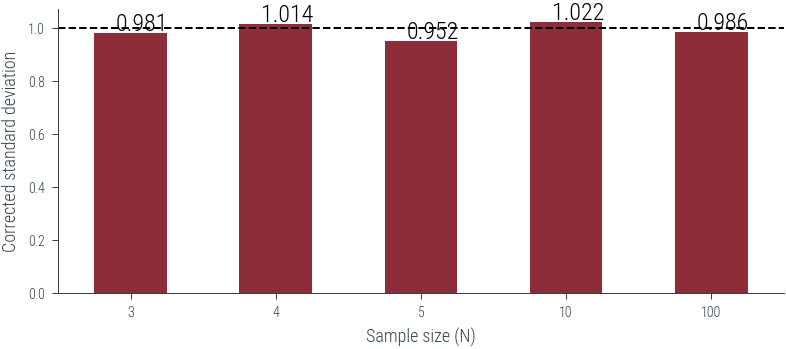

In [58]:
df_unbiased = df*(df.index/(df.index-1.0))

df_unbiased.plot(kind='bar', rot=0)
plt.axhline(1, color='k', linestyle='--')
# Put numbers on top of bars
for i, v in enumerate(df_unbiased):
    plt.text(i - .1, v + .01, f'{v:.3f}', color='k', fontsize=12)

plt.xlabel("Sample size (N)")
plt.ylabel("Corrected standard deviation")
plt.savefig('../figures/corrected-mle-variance-quality.pdf', bbox_inches='tight')